In [ ]:
# Geometric distance L2norm Regression for Homography
# https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog

In [3]:
import numpy as np

In [98]:
# Data init 
M = 4  # number of data
N = 3  # features number
data_x = np.random.rand(N,M)*1000
data_x = data_x
data_x[2,:] = 1
t_m = np.random.rand(N,N)
t_m[2,2] = 1
data_y = np.dot(t_m,data_x.copy().astype(float))

In [99]:
data_x

array([[317.01774853, 202.7995656 , 745.69012875, 956.10167685],
       [859.92436177, 460.49904137, 100.19408643, 164.36002568],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [100]:
t_m = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [102]:
dy = data_y / data_y[-1:, :]

In [101]:
data_y = np.dot(t_m, data_x.copy().astype(float))
print(data_y)

[[7.56531742e+02 6.33202372e+02 1.03369825e+03 1.20567670e+03]
 [8.47437166e+02 4.79870770e+02 6.20725554e+01 9.54797211e+01]
 [9.47503913e-01 9.64975645e-01 8.45577900e-01 8.02582255e-01]]


In [8]:
## test self determine coord
data_x = np.array([[400, 600, 450, 620],
                  [100, 200, 620, 700],
                  [1, 1, 1, 1]]).astype(np.float32)
data_y = np.array([[0, 400, 0, 400],
                  [0, 0, 400, 400],
                  [1, 1, 1, 1]]).astype(np.float32)


In [14]:
DBG = 0
DBG_LOSS = 1
def DEBUG(*args):
    if DBG: print(*args)

def DEBUGLOSS(*args):
    if DBG_LOSS: print(*args)

In [15]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [16]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm', 'update_steps', 'dim','data_m',
                'solver', 'loss_func')
    LOSSFUNCS = {'L2norm':0, 'L1norm':1}
    SOLVERS = {'Grad':0,'Adam':1}

    def __init__(self, var=None, dim=None, iter=500, decay_rate=0.9, norm=1, update_steps=100, data_m=0,
                solver='Grad', loss_func='L2norm'):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.update_steps=update_steps
        self.norm = norm
        self.data_m = data_m
        self.solver = solver
        self.loss_func = loss_func

    def process(self, x, y, method=0):
        if method == 0:
            return x.copy(), y.copy()
        elif method == 1:
            n, m = x.shape
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = x.copy() / self.x_std
            _y = y.copy() / self.x_std
            _x[-1,:] = x[-1,:]
            _y[-1,:] = y[-1,:]
            return _x, _y
        elif method == 2:
            self.x_mean = np.mean(x,axis=1, keepdims=1)
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = (x.copy() - self.x_mean)/self.x_std
            _y = (y.copy() - self.x_mean)/self.x_std
            return _x, _y
        return x.copy(), y.copy()
    
    def pred(W,x):
        return np.dot(W, x)
    
    def computeLoss(self, res):
        n, m = self.dim
        p, q = self.var.val.shape
        if self.loss_func == 'L2norm':
            loss = np.sum(res * res) / (2 * m * n)
        if self.norm > 0:
            loss += (np.sum(self.var.val ** 2) - 1) / (2 * p * q) * self.norm 
        return loss
    
    def lrPolicy(self, iteration, lr):
        if (iteration+1) % self.update_steps == 0:
            lr *= self.decay_rate
        return lr

    def lossDiff(self, pred, y):
        res = (pred - y)
        if self.loss_weights is not None:
            res *= self.loss_weights
        return res

    def computeGradient(self, res, _x, *args):
        n, m = self.dim
        if self.loss_func == 'L2norm':
            tV = np.dot(res, _x.T) / m
        if self.norm > 0:
            tV += self.var.val * self.norm 
        return tV
    
    def computeSolver(self, lr, tV):
        if self.solver == 'Grad':
            dV = lr * tV
        return dV

    def updateWeight(self, dV_masked):
        if self.var.trainable:
            self.var.val -= dV_masked

    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[1] == x.shape[0], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[0] == y.shape[0], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        n, m = self.dim = x.shape
        p, q = self.var.val.shape
        print('processing data')
        _x, _y = self.process(x, y, self.data_m)
        print('output:', _x[:,0], _y[:,0])
        dv_hist = []
        lr= self.lr

        for i in range(self.iter):
            # update policy
            lr = self.lrPolicy(i, lr)

            pred = Regression.pred(self.var.val, _x)
            DEBUG('pred',pred[:,0])

            res = self.lossDiff(pred,y)
            DEBUG('res',res[0,:], '\ntv', np.dot(res, _x.T)[0,:])

            loss = self.computeLoss(res)
            self.j_hist[i,0] = loss

            if (loss < self.err_th):
                return self.var.val
            
            # Gradient
            tV = self.computeGradient(res, _x, m)
            dV = self.computeSolver(lr, tV)

            dv_hist.append(dV[0,0])

            # Update variable
            self.updateWeight(dV * self.var.train_mask)
            DEBUG('dv',dV[0,:],'val',self.var.val[0,:])
            DEBUGLOSS('==============',i,'============', 'loss',loss, lr)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [20]:
var  = Variables(dim=(N,N))
# var.val[:,-1] = 200
var.val[-1,-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=5000, update_steps=400, data_m=0)
reg.err_th = 1e-10
#reg.lr = 0.000002
reg.lr = np.ones((N,N)) * 0.0000035
reg.lr[:,2] = 0.275
reg.norm = 0
reg.loss_weights = np.array([[1,1,1]]).T

In [21]:
x_mean = np.mean(data_x, axis=1, keepdims=1)
x_mean[2,0] = 0
_data_x = (data_x) / np.array([[100,100,100]]).T
_data_y = (data_y) / np.array([[100,100,100]]).T

In [22]:
dv_hist = reg.fit(data_x, data_y)

processing data
output: [400. 100.   1.] [0. 0. 1.]
============== 0 ============ loss 99780.30356089387 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 1 ============ loss 62842.16830484933 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 2 ============ loss 43711.73814984515 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 3 ============ loss 32850.45432442065 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 4 ============ loss 26032.197751106694 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 5 ============ loss 21344.141931629743 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 6 ============ loss 17888.7429486358 [[3.50e-06 3.50e-06 2.75e-01]


============== 151 ============ loss 588.0495671280779 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 152 ============ loss 580.6554586787175 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 153 ============ loss 573.3615919199331 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 154 ============ loss 566.1666078782755 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 155 ============ loss 559.0691660038761 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 156 ============ loss 552.0679439206583 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 157 ============ loss 545.1616371799724 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-0

============== 295 ============ loss 119.03924215468409 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 296 ============ loss 118.00349158028597 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 297 ============ loss 116.98178264307141 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 298 ============ loss 115.9739249810167 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 299 ============ loss 114.97973081283237 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 300 ============ loss 113.99901490297037 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]]
============== 301 ============ loss 113.03159452711607 [[3.50e-06 3.50e-06 2.75e-01]
 [3.50e-06 3.50e-06 2.75e-01]
 [3

============== 413 ============ loss 58.19596430792614 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 414 ============ loss 58.0060893425271 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 415 ============ loss 57.818531883599775 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 416 ============ loss 57.63326364496988 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 417 ============ loss 57.4502566857094 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 418 ============ loss 57.269483405920674 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 419 ============ loss 57.090916542574696 [[3.150e-06 3.

============== 565 ============ loss 45.04507860183522 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 566 ============ loss 45.01571591178498 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 567 ============ loss 44.98671160612761 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 568 ============ loss 44.958061310626455 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 569 ============ loss 44.92976070443306 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 570 ============ loss 44.90180551943703 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 571 ============ loss 44.874191539623446 [[3.150e-06 3

============== 714 ============ loss 43.02535772778935 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 715 ============ loss 43.020646608766924 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 716 ============ loss 43.01599299100004 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 717 ============ loss 43.011396172660234 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 718 ============ loss 43.00685546048572 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 719 ============ loss 43.00237016967683 [[3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]
 [3.150e-06 3.150e-06 2.475e-01]]
============== 720 ============ loss 42.99793962379161 [[3.150e-06 3

============== 847 ============ loss 42.71933811155367 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 848 ============ loss 42.71845942691886 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 849 ============ loss 42.7175903975025 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 850 ============ loss 42.71673091721062 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 851 ============ loss 42.71588088111517 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 852 ============ loss 42.71504018543971 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 85

============== 936 ============ loss 42.66928348571317 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 937 ============ loss 42.668954814503415 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 938 ============ loss 42.668629754819584 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 939 ============ loss 42.668308266976936 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 940 ============ loss 42.667990311727834 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 941 ============ loss 42.6676758502548 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
=============

============== 1067 ============ loss 42.64640668823059 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 1068 ============ loss 42.6463293933026 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 1069 ============ loss 42.64625294771136 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 1070 ============ loss 42.64617734212528 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 1071 ============ loss 42.646102567312596 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
============== 1072 ============ loss 42.646028614145045 [[2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]
 [2.8350e-06 2.8350e-06 2.2275e-01]]
=========

============== 1215 ============ loss 42.64076788034894 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1216 ============ loss 42.64075407573861 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1217 ============ loss 42.64074040768535 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1218 ============ loss 42.64072687483932 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1219 ============ loss 42.64071347586181 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1220 ============ loss 42.64070020942985 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-

============== 1354 ============ loss 42.63972279994314 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1355 ============ loss 42.639719333444084 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1356 ============ loss 42.63971590123676 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1357 ============ loss 42.63971250298139 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1358 ============ loss 42.63970913834212 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1359 ============ loss 42.63970580698595 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e

============== 1493 ============ loss 42.6394603680727 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1494 ============ loss 42.639459497594125 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1495 ============ loss 42.639458635727244 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1496 ============ loss 42.639457782385776 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1497 ============ loss 42.63945693748521 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475e-01]]
============== 1498 ============ loss 42.63945610094293 [[2.55150e-06 2.55150e-06 2.00475e-01]
 [2.55150e-06 2.55150e-06 2.00475

============== 1639 ============ loss 42.639393820985916 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1640 ============ loss 42.63939362997323 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1641 ============ loss 42.639393440662104 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1642 ============ loss 42.639393253036765 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1643 ============ loss 42.639393067081734 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1644 ============ loss 42.639392882782964 [[2.296350e-06 2.296350e

============== 1747 ============ loss 42.63938053461235 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1748 ============ loss 42.63938046191726 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1749 ============ loss 42.63938038986965 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1750 ============ loss 42.639380318463935 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1751 ============ loss 42.63938024769332 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1752 ============ loss 42.63938017755396 [[2.296350e-06 2.296350e-06 

============== 1877 ============ loss 42.63937492313644 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1878 ============ loss 42.63937490041247 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1879 ============ loss 42.639374877891605 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1880 ============ loss 42.63937485557012 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1881 ============ loss 42.63937483344797 [[2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]
 [2.296350e-06 2.296350e-06 1.804275e-01]]
============== 1882 ============ loss 42.63937481152313 [[2.296350e-06 2.296350e-06 

============== 2037 ============ loss 42.639373002428265 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2038 ============ loss 42.63937299736987 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2039 ============ loss 42.639372992351475 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2040 ============ loss 42.639372987373605 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2041 ============ loss 42.639372982435376 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2042 ============ los

============== 2159 ============ loss 42.63937260775548 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2160 ============ loss 42.63937260586062 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2161 ============ loss 42.63937260398102 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2162 ============ loss 42.63937260211642 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2163 ============ loss 42.639372600266874 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2164 ============ loss 4

============== 2274 ============ loss 42.639372465050606 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2275 ============ loss 42.63937246429958 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2276 ============ loss 42.6393724635546 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2277 ============ loss 42.63937246281607 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2278 ============ loss 42.6393724620828 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2279 ============ loss 42.

============== 2394 ============ loss 42.639372407033726 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2395 ============ loss 42.63937240674799 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2396 ============ loss 42.63937240646434 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2397 ============ loss 42.63937240618312 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2398 ============ loss 42.639372405904076 [[2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]
 [2.0667150e-06 2.0667150e-06 1.6238475e-01]]
============== 2399 ============ loss 

 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2540 ============ loss 42.63937238371159 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2541 ============ loss 42.639372383622565 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2542 ============ loss 42.63937238353444 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2543 ============ loss 42.63937238344629 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2544 ============ loss 42.639372383359245 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.4614627

============== 2639 ============ loss 42.63937237739815 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2640 ============ loss 42.639372377354476 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2641 ============ loss 42.639372377311496 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2642 ============ loss 42.63937237726858 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2643 ============ loss 42.639372377225946 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.4614627

 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2797 ============ loss 42.639372373293334 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2798 ============ loss 42.639372373279166 [[1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]
 [1.86004350e-06 1.86004350e-06 1.46146275e-01]]
============== 2799 ============ loss 42.639372373265566 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2800 ============ loss 42.63937237325293 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2801 ============ loss 42.63937237324108 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.315316

 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2920 ============ loss 42.63937237223438 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2921 ============ loss 42.63937237222895 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2922 ============ loss 42.639372372223384 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2923 ============ loss 42.63937237221777 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2924 ============ loss 42.639372372212215 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.3153164

============== 2998 ============ loss 42.63937237189185 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 2999 ============ loss 42.63937237188842 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3000 ============ loss 42.63937237188511 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3001 ============ loss 42.63937237188201 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3002 ============ loss 42.63937237187833 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-

============== 3113 ============ loss 42.639372371619636 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3114 ============ loss 42.63937237161776 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3115 ============ loss 42.63937237161608 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3116 ============ loss 42.63937237161475 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]]
============== 3117 ============ loss 42.63937237161281 [[1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e-01]
 [1.67403915e-06 1.67403915e-06 1.31531648e

============== 3255 ============ loss 42.639372371475716 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3256 ============ loss 42.63937237147506 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3257 ============ loss 42.63937237147414 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3258 ============ loss 42.63937237147374 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3259 ============ loss 42.6393723714732 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-

============== 3391 ============ loss 42.63937237142036 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3392 ============ loss 42.63937237142007 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3393 ============ loss 42.63937237141943 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3394 ============ loss 42.639372371419476 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3395 ============ loss 42.639372371419434 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483

============== 3522 ============ loss 42.63937237139601 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3523 ============ loss 42.63937237139594 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3524 ============ loss 42.63937237139578 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3525 ============ loss 42.63937237139583 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]]
============== 3526 ============ loss 42.63937237139553 [[1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-01]
 [1.50663524e-06 1.50663524e-06 1.18378483e-

============== 3633 ============ loss 42.63937237138645 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3634 ============ loss 42.63937237138614 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3635 ============ loss 42.63937237138616 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3636 ============ loss 42.63937237138584 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3637 ============ loss 42.63937237138607 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-

============== 3737 ============ loss 42.63937237138142 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3738 ============ loss 42.63937237138169 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3739 ============ loss 42.639372371381405 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3740 ============ loss 42.63937237138148 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3741 ============ loss 42.6393723713812 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-

============== 3861 ============ loss 42.6393723713785 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3862 ============ loss 42.63937237137836 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3863 ============ loss 42.639372371378315 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3864 ============ loss 42.63937237137825 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3865 ============ loss 42.63937237137877 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-

============== 3985 ============ loss 42.63937237137661 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3986 ============ loss 42.63937237137693 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3987 ============ loss 42.63937237137669 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3988 ============ loss 42.63937237137696 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]]
============== 3989 ============ loss 42.639372371376616 [[1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e-01]
 [1.35597171e-06 1.35597171e-06 1.06540634e

============== 4125 ============ loss 42.63937237137588 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4126 ============ loss 42.639372371376105 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4127 ============ loss 42.639372371376076 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4128 ============ loss 42.63937237137588 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4129 ============ loss 42.63937237137627 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710

============== 4257 ============ loss 42.6393723713752 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4258 ============ loss 42.63937237137565 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4259 ============ loss 42.6393723713755 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4260 ============ loss 42.63937237137564 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4261 ============ loss 42.63937237137558 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02

============== 4356 ============ loss 42.63937237137539 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4357 ============ loss 42.63937237137559 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4358 ============ loss 42.63937237137577 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4359 ============ loss 42.63937237137528 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]]
============== 4360 ============ loss 42.63937237137532 [[1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-02]
 [1.22037454e-06 1.22037454e-06 9.58865710e-

 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4443 ============ loss 42.63937237137508 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4444 ============ loss 42.63937237137554 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4445 ============ loss 42.63937237137531 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4446 ============ loss 42.63937237137545 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4447 ============ loss 42.63937237137548 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e

============== 4584 ============ loss 42.63937237137513 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4585 ============ loss 42.639372371375416 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4586 ============ loss 42.639372371375266 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4587 ============ loss 42.63937237137504 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4588 ============ loss 42.63937237137519 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139

 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4704 ============ loss 42.63937237137532 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4705 ============ loss 42.639372371374854 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4706 ============ loss 42.6393723713753 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4707 ============ loss 42.63937237137541 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e-02]]
============== 4708 ============ loss 42.63937237137514 [[1.09833709e-06 1.09833709e-06 8.62979139e-02]
 [1.09833709e-06 1.09833709e-06 8.62979139e

============== 4842 ============ loss 42.63937237137512 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4843 ============ loss 42.63937237137507 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4844 ============ loss 42.639372371375124 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4845 ============ loss 42.63937237137532 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4846 ============ loss 42.63937237137516 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e

============== 4978 ============ loss 42.63937237137507 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4979 ============ loss 42.63937237137512 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4980 ============ loss 42.63937237137508 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4981 ============ loss 42.63937237137499 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]]
============== 4982 ============ loss 42.639372371374776 [[9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e-02]
 [9.88503378e-07 9.88503378e-07 7.76681225e

In [23]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [24]:
reg.var.val

array([[ 2.22277439e+00, -1.52885325e-01, -8.88367190e+02],
       [-3.95700383e-01,  8.11446211e-01,  7.61392329e+01],
       [-6.74331704e-20,  9.72686770e-20,  1.00000000e+00]])

In [25]:
for idx in range(4):
    test_x = data_x[:,idx]
    test_y = data_y[:,idx]
    pred_y = np.dot(reg.var.val,data_x[:,idx:idx+1])
    print (test_y, pred_y)

[0. 0. 1.] [[-14.54596672]
 [ -0.99629923]
 [  1.        ]]
[400.   0.   1.] [[414.72037891]
 [  1.00824523]
 [  1.        ]]
[  0. 400.   1.] [[ 17.09238379]
 [401.17071111]
 [  1.        ]]
[400. 400.   1.] [[382.7332042 ]
 [398.81734284]
 [  1.        ]]


In [1176]:
test_y, pred_y

(array([1.24692776e+03, 8.72551513e+02, 8.22174312e-01]),
 array([[836.42794144],
        [270.5636486 ],
        [  0.89838256]]))

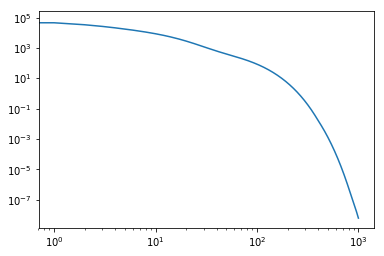

In [1311]:
import matplotlib.pyplot as plt
plt.loglog(reg.j_hist)

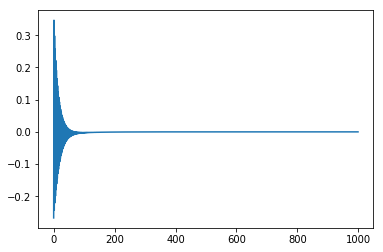

In [1314]:
plt.plot(np.array(dv_hist))

In [480]:
def compute_cost(X, y, params):
    n_samples = len(y)
    h = X @ params
    return (1/(2*n_samples))*np.sum((h-y)**2)
def gradient_descent(X, y, params, learning_rate, n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))

    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X, y, params)

    return (J_history, params)

In [481]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [482]:
dataset = load_boston()

X = dataset.data
y = dataset.target[:,np.newaxis]

print("Total samples in our dataset is: {}".format(X.shape[0]))


Total samples in our dataset is: 506


In [229]:
n_samples = len(y)

mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X-mu) / sigma

X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

Initial cost is:  296.0734584980237 

Optimal parameters are: 
 [[22.53279993]
 [-0.83980839]
 [ 0.92612237]
 [-0.17541988]
 [ 0.72676226]
 [-1.82369448]
 [ 2.78447498]
 [-0.05650494]
 [-2.96695543]
 [ 1.80785186]
 [-1.1802415 ]
 [-1.99990382]
 [ 0.85595908]
 [-3.69524414]] 

Final cost is:  [11.00713381]


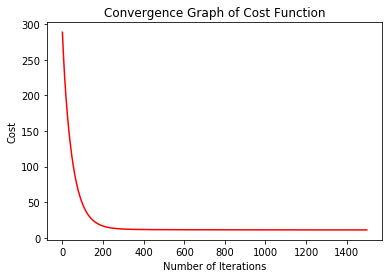

In [230]:
n_iters = 1500
learning_rate = 0.01

initial_cost = compute_cost(X, y, params)

print("Initial cost is: ", initial_cost, "\n")

(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)

print("Optimal parameters are: \n", optimal_params, "\n")

print("Final cost is: ", J_history[-1])

plt.plot(range(len(J_history)), J_history, 'r')

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

In [278]:
class LinearRegression():
    def __init__(self, X, y, alpha=0.03, n_iter=1500):

        self.alpha = alpha
        self.n_iter = n_iter
        self.n_samples = len(y)
        self.n_features = np.size(X, 1)
        self.X = np.hstack((np.ones(
            (self.n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))
        self.y = y[:, np.newaxis]
        self.params = np.zeros((self.n_features + 1, 1))
        self.coef_ = None
        self.intercept_ = None
    def fit(self):

        for i in range(self.n_iter):
            self.params = self.params - (self.alpha/self.n_samples) * \
            self.X.T @ (self.X @ self.params - self.y)

        self.intercept_ = self.params[0]
        self.coef_ = self.params[1:]

        return self

    def score(self, X=None, y=None):

        if X is None:
            X = self.X
        else:
            n_samples = np.size(X, 0)
            X = np.hstack((np.ones(
                (n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))

        if y is None:
            y = self.y
        else:
            y = y[:, np.newaxis]

        y_pred = X @ self.params
        score = 1 - (((y - y_pred)**2).sum() / ((y - y.mean())**2).sum())

        return score

    def predict(self, X):
        n_samples = np.size(X, 0)
        y = np.hstack((np.ones((n_samples, 1)), (X-np.mean(X, 0)) \
                            / np.std(X, 0))) @ self.params
        return y

    def get_params(self):

        return self.params

In [296]:
a = 2.71
b = -2
N = 100
x = np.linspace(0, 10, N)
x = np.expand_dims(x,1)
y = a *x + b + np.random.rand(N,1) / 0.01


In [298]:
lr = LinearRegression(x,y)
lr.fit()

In [16]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [64]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large. reprojection loss
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
        
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                invH = np.linalg.inv(self.var.val)
                reproj = np.dot(pred, invH)
                res_re = (reproj - _x) * self.loss_weights
                loss = np.sum(res * res) / (2 * m * n) + np.sum(res_re * res_re) / (2 * m * n)
            elif method == 'LMS':
                loss = np.sum(np.median(res * res, axis=0)) / (2 * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                # https://math.stackexchange.com/questions/190424/how-to-evaluate-the-derivatives-of-matrix-inverse
                tV = np.dot(_x.T, res) / m
                dH = -np.dot(np.dot(invH, self.var.val.T), invH)
                dR = np.dot(pred, dH)
                tV += (np.dot(dR.T, res_re) / m)
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            elif method == 'LMS':
                dV = (lr) # working on
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [155]:
rand = np.random.rand(N,N)
var  = Variables(val=rand,dim=(N,N))
#var  = Variables(dim=(N,N))
var.val[N-1,N-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=1000)
reg.err_th = 1e-10
#reg.lr = 0.000001
#reg.lr = np.ones((N,N)) * 0.01
#reg.lr[-1,:] = 0.0001
reg.lr = 0.1
reg.norm = 1e-8
reg.loss_weights = np.array([[1,1,1]])

In [156]:
dv_hist = reg.fit(data_x, data_y)

processing data
============== 0 ============ loss 116014.94453889747 0.09000000000000001
============== 1 ============ loss 22144.163619434694 0.09000000000000001
============== 2 ============ loss 6089.0714430236585 0.09000000000000001
============== 3 ============ loss 3273.3673188490893 0.09000000000000001
============== 4 ============ loss 2712.7321334867115 0.09000000000000001
============== 5 ============ loss 2538.658798665922 0.09000000000000001
============== 6 ============ loss 2433.211939650282 0.09000000000000001
============== 7 ============ loss 2342.2069540665484 0.09000000000000001
============== 8 ============ loss 2256.326148113136 0.09000000000000001
============== 9 ============ loss 2173.887221394699 0.09000000000000001
============== 10 ============ loss 2094.5101826155715 0.09000000000000001
============== 11 ============ loss 2018.0399845150655 0.09000000000000001
============== 12 ============ loss 1944.3631428361227 0.09000000000000001
============== 13 =====

============== 118 ============ loss 37.726046908211856 0.09000000000000001
============== 119 ============ loss 36.34874191500853 0.09000000000000001
============== 120 ============ loss 35.021720929076224 0.09000000000000001
============== 121 ============ loss 33.74314813274945 0.09000000000000001
============== 122 ============ loss 32.511254732179815 0.09000000000000001
============== 123 ============ loss 31.32433651036591 0.09000000000000001
============== 124 ============ loss 30.180751469519826 0.09000000000000001
============== 125 ============ loss 29.078917559506188 0.09000000000000001
============== 126 ============ loss 28.01731048921618 0.09000000000000001
============== 127 ============ loss 26.99446161784433 0.09000000000000001
============== 128 ============ loss 26.008955923153707 0.09000000000000001
============== 129 ============ loss 25.05943004391651 0.09000000000000001
============== 130 ============ loss 24.144570393824324 0.09000000000000001
============== 131

============== 262 ============ loss 0.22570251284208398 0.08100000000000002
============== 263 ============ loss 0.21831116516551327 0.08100000000000002
============== 264 ============ loss 0.21116291011560792 0.08100000000000002
============== 265 ============ loss 0.20424975268781856 0.08100000000000002
============== 266 ============ loss 0.19756396082259015 0.08100000000000002
============== 267 ============ loss 0.19109805675757918 0.08100000000000002
============== 268 ============ loss 0.18484480866408198 0.08100000000000002
============== 269 ============ loss 0.17879722255867905 0.08100000000000002
============== 270 ============ loss 0.17294853448075748 0.08100000000000002
============== 271 ============ loss 0.16729220292741193 0.08100000000000002
============== 272 ============ loss 0.16182190153712836 0.08100000000000002
============== 273 ============ loss 0.15653151201398585 0.08100000000000002
============== 274 ============ loss 0.1514151172847922 0.08100000000000002


============== 394 ============ loss 0.003685811862059613 0.08100000000000002
============== 395 ============ loss 0.0035963618601692797 0.08100000000000002
============== 396 ============ loss 0.003509853897663259 0.08100000000000002
============== 397 ============ loss 0.0034261912124012367 0.08100000000000002
============== 398 ============ loss 0.0033452802246455946 0.08100000000000002
============== 399 ============ loss 0.003267030432427864 0.08100000000000002
============== 400 ============ loss 0.0031913543102859085 0.07290000000000002
============== 401 ============ loss 0.0031254308476047193 0.07290000000000002
============== 402 ============ loss 0.003061460446536621 0.07290000000000002
============== 403 ============ loss 0.0029993852469360326 0.07290000000000002
============== 404 ============ loss 0.002939149102754309 0.07290000000000002
============== 405 ============ loss 0.0028806975312610427 0.07290000000000002
============== 406 ============ loss 0.002823977663785937

============== 532 ============ loss 0.0010082589386043977 0.07290000000000002
============== 533 ============ loss 0.0010070150477054201 0.07290000000000002
============== 534 ============ loss 0.0010058080217918597 0.07290000000000002
============== 535 ============ loss 0.0010046367685281061 0.07290000000000002
============== 536 ============ loss 0.0010035002279409756 0.07290000000000002
============== 537 ============ loss 0.001002397371463358 0.07290000000000002
============== 538 ============ loss 0.0010013272010006076 0.07290000000000002
============== 539 ============ loss 0.0010002887480309516 0.07290000000000002
============== 540 ============ loss 0.0009992810727265818 0.07290000000000002
============== 541 ============ loss 0.0009983032631053898 0.07290000000000002
============== 542 ============ loss 0.0009973544342055227 0.07290000000000002
============== 543 ============ loss 0.0009964337272843676 0.07290000000000002
============== 544 ============ loss 0.00099554030904

============== 688 ============ loss 0.0009668006797206002 0.06561000000000002
============== 689 ============ loss 0.0009667873536254029 0.06561000000000002
============== 690 ============ loss 0.0009667743844593516 0.06561000000000002
============== 691 ============ loss 0.0009667617626805677 0.06561000000000002
============== 692 ============ loss 0.0009667494790019137 0.06561000000000002
============== 693 ============ loss 0.0009667375243844198 0.06561000000000002
============== 694 ============ loss 0.0009667258900304918 0.06561000000000002
============== 695 ============ loss 0.0009667145673774964 0.06561000000000002
============== 696 ============ loss 0.0009667035480915269 0.06561000000000002
============== 697 ============ loss 0.000966692824061232 0.06561000000000002
============== 698 ============ loss 0.0009666823873919451 0.06561000000000002
============== 699 ============ loss 0.0009666722303998806 0.06561000000000002
============== 700 ============ loss 0.00096666234560

============== 868 ============ loss 0.0009663089577844541 0.05904900000000002
============== 869 ============ loss 0.0009663088547838579 0.05904900000000002
============== 870 ============ loss 0.0009663087543644181 0.05904900000000002
============== 871 ============ loss 0.0009663086564628259 0.05904900000000002
============== 872 ============ loss 0.0009663085610173104 0.05904900000000002
============== 873 ============ loss 0.0009663084679675972 0.05904900000000002
============== 874 ============ loss 0.0009663083772548809 0.05904900000000002
============== 875 ============ loss 0.0009663082888217737 0.05904900000000002
============== 876 ============ loss 0.0009663082026122944 0.05904900000000002
============== 877 ============ loss 0.0009663081185718121 0.05904900000000002
============== 878 ============ loss 0.0009663080366470291 0.05904900000000002
============== 879 ============ loss 0.0009663079567859404 0.05904900000000002
============== 880 ============ loss 0.0009663078789

In [153]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [158]:
reg.var.val

array([[ 7.90900075e-01,  8.06359397e-02,  4.34671372e+02],
       [-1.33281047e-01,  9.58667338e-01,  6.55963190e+01],
       [ 6.01986564e-01,  6.91658939e-01,  1.00000000e+00]])

In [160]:
for idx in range(4):
    test_x = data_x[idx]
    test_y = data_y[idx]
    pred_y = np.dot(data_x[idx], reg.var.val)
    print (data_x[idx], test_y, pred_y)

[366 632   1] [   205.59822578    635.80706082 200547.58662   ] [   205.83779247    636.08217029 200547.59589302]
[691 937   1] [   422.36864044    954.84210175 361822.66579   ] [   422.22959761    954.68238868 361822.66920104]
[386  74   1] [2.95937776e+02 1.02656381e+02 1.72638300e+05] [2.96026618e+02 1.02758515e+02 1.72638277e+05]
[570 609   1] [   370.2923331    630.5347429 287711.846716 ] [   370.24687188    630.48255322 287711.84051069]


In [109]:
def calc_corresp(u, v):
    # 2N * 9
    a = np.array([[-u[0,0], -u[0,1], -1, 0, 0, 0, u[0,0]*v[0,0], u[0,1]*v[0,0], v[0,0]],
                  [0, 0, 0, -u[0,0], -u[0,1], -1, u[0,0]*v[0,1], u[0,1]*v[0,1], v[0,1]],
                  [-u[1,0], -u[1,1], -1, 0, 0, 0, u[1,0]*v[1,0], u[1,1]*v[1,0], v[1,0]],
                  [0, 0, 0, -u[1,0], -u[1,1], -1, u[1,0]*v[1,1], u[1,1]*v[1,1], v[1,1]],
                  [-u[2,0], -u[2,1], -1, 0, 0, 0, u[2,0]*v[2,0], u[2,1]*v[2,0], v[2,0]],
                  [0, 0, 0, -u[2,0], -u[2,1], -1, u[2,0]*v[2,1], u[2,1]*v[2,1], v[2,1]],
                  [-u[3,0], -u[3,1], -1, 0, 0, 0, u[3,0]*v[3,0], u[3,1]*v[3,0], v[3,0]],
                  [0, 0, 0, -u[3,0], -u[3,1], -1, u[3,0]*v[3,1], u[3,1]*v[3,1], v[3,1]]]).astype(np.float32)
    return a

def calc_correspLinear(u, v):
    # 2N * 8 see https://scm_mos.gitlab.io/vision/homography-matrix/
    a = np.array([[u[0,0], u[0,1], 1, 0, 0, 0, -u[0,0]*v[0,0], -u[0,1]*v[0,0]],
                  [0, 0, 0, u[0,0], u[0,1], 1, -u[0,0]*v[0,1], -u[0,1]*v[0,1]],
                  [u[1,0], u[1,1], 1, 0, 0, 0, -u[1,0]*v[1,0], -u[1,1]*v[1,0]],
                  [0, 0, 0, u[1,0], u[1,1], 1, -u[1,0]*v[1,1], -u[1,1]*v[1,1]],
                  [u[2,0], u[2,1], 1, 0, 0, 0, -u[2,0]*v[2,0], -u[2,1]*v[2,0]],
                  [0, 0, 0, u[2,0],u[2,1], 1, -u[2,0]*v[2,1], -u[2,1]*v[2,1]],
                  [u[3,0], u[3,1], 1, 0, 0, 0, -u[3,0]*v[3,0], -u[3,1]*v[3,0]],
                  [0, 0, 0, u[3,0], u[3,1], 1, -u[3,0]*v[3,1], -u[3,1]*v[3,1]]]).astype(np.float32)

    b = np.array([[v[0,0], v[0,1], v[1,0], v[1,1], v[2,0], v[2,1], v[3,0], v[3,1]]]).astype(np.float32).T
    return a, b

def calcHomography(u, v):
    """DLT algo"""

    # get assemable matrix
    mat = calc_corresp(u, v)
    
    # svd composition
    u, s, v = np.linalg.svd(mat)
    
    # reshape
    h = v[-1].reshape(3, 3)
    
    # norm
    h = h / h.item(8)
    return h

def calcHomographyLinear(u, v):
    """Linear"""

    # get assemable matrix
    A, b = calc_correspLinear(u, v)
    
    # solver linear AH = b, H = (A.T * A)^-1 * A.T * b
    h = np.linalg.inv(A.T @ A) @ (A.T @ b)
    
    H = np.array([[h.item(0), h.item(1), h.item(2)],
                  [h.item(3), h.item(4), h.item(5)],
                  [h.item(6), h.item(7), 1]])
    return H

In [97]:
## test self determine coord
data_x = np.array([[400., 600, 450, 620],
                  [100, 200, 620, 700]]).astype(np.float32).T
data_y = np.array([[0, 400, 0, 400],
                  [0., 0, 400, 400]]).astype(np.float32).T


In [110]:
data_x.T

array([[317.01774853, 859.92436177,   1.        ],
       [202.7995656 , 460.49904137,   1.        ],
       [745.69012875, 100.19408643,   1.        ],
       [956.10167685, 164.36002568,   1.        ]])

In [111]:
dy.T[:,:2]

array([[ 798.44709028,  894.38909427],
       [ 656.18482182,  497.28795948],
       [1222.4754858 ,   73.408441  ],
       [1502.24689976,  118.96565194]])

In [112]:
h = calcHomography(data_x.T[:,:2], dy.T[:,:2])

In [113]:
h

array([[ 7.9227197e-01,  8.2211740e-02,  4.3467151e+02],
       [-1.3350204e-01,  9.5841366e-01,  6.5596306e+01],
       [-2.0924887e-04,  1.6093743e-05,  1.0000000e+00]], dtype=float32)

In [114]:
h = calcHomographyLinear(data_x.T[:,:2], dy.T[:,:2])

In [115]:
h

array([[ 7.92175293e-01,  8.22143555e-02,  4.34671875e+02],
       [-1.33506775e-01,  9.58404541e-01,  6.56093750e+01],
       [-2.09301710e-04,  1.61230564e-05,  1.00000000e+00]])

In [116]:
h @ data_x

array([[7.56503630e+02, 6.33184312e+02, 1.03362656e+03, 1.20558475e+03],
       [8.47440771e+02, 4.79878631e+02, 6.20811583e+01, 9.54867186e+01],
       [9.47512252e-01, 9.64978356e-01, 8.45541216e-01, 8.02536270e-01]])

In [117]:
data_y

array([[7.56531742e+02, 6.33202372e+02, 1.03369825e+03, 1.20567670e+03],
       [8.47437166e+02, 4.79870770e+02, 6.20725554e+01, 9.54797211e+01],
       [9.47503913e-01, 9.64975645e-01, 8.45577900e-01, 8.02582255e-01]])